For a better version of the code, please take a look at `clean_stack_exchange_qa.py`

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import re

from tqdm.notebook import tqdm
from tqdm.auto import tqdm
tqdm.pandas()
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

//anaconda3/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
PATH_TO_SX_PARSED = Path('../../input/sx_dump/stackexchange_parsed')
PATH_TO_SAVE = Path('../../input')

In [3]:
dumps = PATH_TO_SX_PARSED.glob('*')
dumps = [path for path in dumps if path.joinpath('questions.tsv').exists()]

In [4]:
all_questions, all_answers = [], []
offset = 0

for dump in tqdm(dumps):
    questions = pd.read_csv(dump / 'questions.tsv', sep='\t')
    answers = pd.read_csv(dump / 'answers.tsv', sep='\t')
    
    questions['host'] = answers['host'] = dump.name
       
    accepted_answers = questions['AcceptedAnswerId'].dropna().astype(int)
    answers['is_answer_accepted'] = answers['Id'].astype(int).isin(accepted_answers)
    
    questions['Id'] = questions['Id'].astype(int) + offset
    answers['Id'] = answers['Id'].astype(int) + offset
    answers['ParentId'] = answers['ParentId'].astype(int) + offset

    
    all_questions.append(questions)
    all_answers.append(answers)
    
    offset = max(questions['Id'].max(), answers['Id'].max()) + 1

In [5]:
len(all_answers)

1

In [6]:
all_questions = pd.concat(all_questions, sort=False).reset_index()
all_answers = pd.concat(all_answers, sort=False).reset_index()

In [7]:
all_questions.shape, all_answers.shape

((2714, 17), (4908, 13))

In [8]:
answers['is_answer_accepted'].mean()

0.2899348003259984

In [9]:
html_pattern = re.compile(r'<.*?>')

question_body = all_questions['Body'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))
question_title = all_questions['Title'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))

In [10]:
question_body_cleaned = question_body.progress_apply(lambda s: s.replace('\n','')).values

In [11]:
n_jobs = 4
chunksize = 100000
n_chunks = int(len(question_body_cleaned) / chunksize) + 1

In [12]:
%%time
import fasttext
from multiprocessing import Pool

def predict_lang(sentences):
    model = fasttext.load_model('../../input/lid.176.bin')
    return model.predict(list(sentences), k=1)[0]

with Pool(n_jobs) as pool:
    question_lang = list(
        tqdm(
            pool.imap(predict_lang, [question_body_cleaned[i*chunksize : (i+1)*chunksize] 
                                     for i in range(n_chunks)]),
            total = n_chunks
        )
    )
    
question_lang = list(map(np.array, question_lang))
question_lang = np.vstack(question_lang).flatten()


CPU times: user 59.7 ms, sys: 40.7 ms, total: 100 ms
Wall time: 564 ms


In [13]:
question_lang = np.array([l[-2:] for l in question_lang])

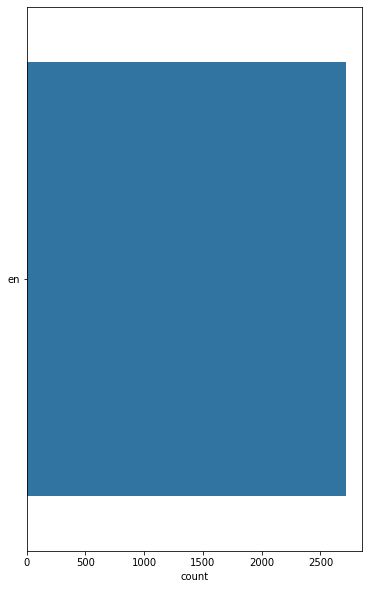

In [14]:
plt.figure(figsize=(6,10))
sns.countplot(y=question_lang, orient='h');

In [15]:
question_ans_agg_features = pd.concat([
    all_answers.groupby('ParentId')['Score'].max().rename('answers_max_score'),
    all_answers.groupby('ParentId')['Score'].mean().rename('answers_mean_score')
], axis=1, sort=False)

In [16]:
question_features = all_questions[['Id','host','username','Score','ViewCount','FavoriteCount','AnswerCount']]
question_features = question_features.merge(question_ans_agg_features, left_on='Id', right_on='ParentId', how='left')
question_features = pd.concat([question_features, question_title, question_body], axis=1, sort=False)

question_features = question_features.iloc[
        (question_lang=='en') &
        (all_questions['AnswerCount'].ravel() != 0)]

In [17]:
print(question_features.columns)

Index(['Id', 'host', 'username', 'Score', 'ViewCount', 'FavoriteCount',
       'AnswerCount', 'answers_max_score', 'answers_mean_score', 'Title',
       'Body'],
      dtype='object')


In [18]:
question_features.columns = ['id', 'host', 'question_username', 'question_score', 'question_views', 'question_favs',
       'answers_count', 'answers_max_score', 'answers_mean_score', 'title', 'body']

In [19]:
def select_answers(all_answers, max_answers_per_question =2):
    answer_ids = all_answers[['Id','ParentId','is_answer_accepted']]

    selected_answers = answer_ids['Id'][answer_ids['is_answer_accepted']].tolist()
    n_additional = max_answers_per_question - (answer_ids.groupby('ParentId')['is_answer_accepted'].sum() > 0).astype(int)

    additional_answers = answer_ids.merge(n_additional.rename('n_additional').reset_index(), on='ParentId')

    while len(additional_answers) > 0:
        print(len(additional_answers))
        additional_answers = additional_answers[~additional_answers['Id'].isin(selected_answers)]
        additional_answers = additional_answers[additional_answers['n_additional'] > 0]
        additional_answers = additional_answers.iloc[np.random.permutation(len(additional_answers))].reset_index(drop=True)
        selected_answers += additional_answers['Id'].loc[additional_answers['ParentId'].drop_duplicates().index].tolist()

        additional_answers['n_additional'] = additional_answers['n_additional'] - 1
    return selected_answers

In [20]:
selected_answers = all_answers['Id'].isin(select_answers(all_answers))

4908
3485
971


In [21]:
answer_features = all_answers[selected_answers][['ParentId', 'username', 'Body', 'Score','is_answer_accepted']]

In [22]:
answer_features['Body'] = answer_features['Body'].astype(str).progress_apply(lambda s: html_pattern.sub('', s))

In [23]:
print(answer_features.columns)

Index(['ParentId', 'username', 'Body', 'Score', 'is_answer_accepted'], dtype='object')


In [24]:
answer_features.columns = ['ParentId', 'answer_username', 'answer', 'answer_score', 'is_answer_accepted']

In [25]:
qa_features = question_features.merge(answer_features, left_on='id', right_on='ParentId', how='inner')

In [26]:
qa_features.drop(columns=['ParentId'], inplace=True)

In [27]:
qa_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3899 entries, 0 to 3898
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  3899 non-null   int64  
 1   host                3899 non-null   object 
 2   question_username   3899 non-null   object 
 3   question_score      3899 non-null   int64  
 4   question_views      3899 non-null   int64  
 5   question_favs       989 non-null    float64
 6   answers_count       3899 non-null   int64  
 7   answers_max_score   3899 non-null   float64
 8   answers_mean_score  3899 non-null   float64
 9   title               3899 non-null   object 
 10  body                3899 non-null   object 
 11  answer_username     3899 non-null   object 
 12  answer              3899 non-null   object 
 13  answer_score        3899 non-null   int64  
 14  is_answer_accepted  3899 non-null   bool   
dtypes: bool(1), float64(3), int64(5), object(6)
memory usag

In [28]:
targets = [ 'question_score', 'question_views', 'question_favs', 
           'answers_count', 'answers_max_score',  'answers_mean_score', 'answer_score', 'is_answer_accepted']

qa_features[targets] = qa_features[targets].fillna(0)
qa_features[targets] = np.sign(qa_features[targets]) * np.log1p(np.abs(qa_features[targets].astype('float')))
qa_features[targets] = qa_features[targets] / qa_features[targets].std()

In [29]:
qa_features.head()

,id,host,question_username,question_score,question_views,question_favs,answers_count,answers_max_score,answers_mean_score,title,body,answer_username,answer,answer_score,is_answer_accepted
0,1,3dprinting.stackexchange.com,Adam Davis,3.76781,3.91261,0,3.18806,3.74932,3.43195,How to obtain high resolution prints in a shor...,When I've printed an object I've had to choose...,hroncok,You could experiment with slicing. For example...,3.21337,2.07692
1,1,3dprinting.stackexchange.com,Adam Davis,3.76781,3.91261,0,3.18806,3.74932,3.43195,How to obtain high resolution prints in a shor...,When I've printed an object I've had to choose...,plaintoothpaste,For FDM technologies in general with a single ...,1.60668,0
2,4,3dprinting.stackexchange.com,Adam Davis,4.54164,3.92155,2.77997,4.67042,3.32048,3.43195,Are there any metals that exhibit a large glas...,Plastic is used in 3D FDM/FFF printing partly ...,TextGeek,"I""m no expert on this, but the article at http...",2.62039,0
3,4,3dprinting.stackexchange.com,Adam Davis,4.54164,3.92155,2.77997,4.67042,3.32048,3.43195,Are there any metals that exhibit a large glas...,Plastic is used in 3D FDM/FFF printing partly ...,Ryan Carlyle,A few things are required for effective extrus...,2.84583,2.07692
4,2,3dprinting.stackexchange.com,kenorb,5.29103,5.52632,3.50793,5.1995,5.19514,4.52199,Is 3D printing safe for your health?,"I would like to buy a 3D printer, but I'm conc...",Tom van der Zanden,There is very little information about safety ...,4.45251,2.07692


In [30]:
qa_features.rename(columns={'body': 'question_body',
                                'title': 'question_title'}).to_csv(PATH_TO_SAVE / 'qa_stackexchange_cleaned.csv',
                                                                   index=False)
qa_features.rename(columns={'body': 'question_body',
                            'title': 'question_title'}).head(50).to_csv(PATH_TO_SAVE / 'qa_stackexchange_cleaned_toy.csv',
                                                                   index=False)